### 作业6：完成课件中P.94-P.105中的代码

### 1.词嵌入

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,GRU,SimpleRNN,RNN,BatchNormalization,LSTMCell

In [2]:
model=Sequential()
model.add(Embedding(1000,64,input_length=10))
input_array = np.random.randint(1000, size=(32, 10))
model.compile('rmsprop','mse')
output_array = model.predict(input_array)
print(output_array.shape)

(32, 10, 64)


In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 64)            64000     
Total params: 64,000
Trainable params: 64,000
Non-trainable params: 0
_________________________________________________________________


### 2.LSTM网络

In [4]:
model=Sequential()
# 添加一个1000词，64维的词嵌入向量（输入层）
model.add(Embedding(input_dim=1000, output_dim=64))
# 添加一个128单元的LSTM层（隐层）
model.add(LSTM(128))
# 添加一个10个单元的全连接层（输出层）
model.add(Dense(10))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


### 3.GRU

In [5]:
model=Sequential()
# 添加一个1000词，64维的词嵌入向量（输入层）
model.add(Embedding(input_dim=1000, output_dim=64))

# 当return_sequences=True时，GRU的输出shape为(batch_size,timesteps, 256)
model.add(GRU(256,return_sequences=True))
# SimpleRNN的输出shape为(batch_size, 128)
model.add(SimpleRNN(128))

model.add(Dense(10))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
gru (GRU)                    (None, None, 256)         247296    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               49280     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 361,866
Trainable params: 361,866
Non-trainable params: 0
_________________________________________________________________


### 4.MNIST

In [6]:
batch_size = 64
# Each MNIST image batch is a tensor of shape
# (batch_size, 28, 28).
# Each input sequence will be of size (28, 28)
# (height is treated like time).
input_dim = 28
units = 64
output_size = 10 # labels are from 0 to 9

In [7]:
model=Sequential([
    RNN(LSTMCell(units),input_shape=(None,input_dim)),
    BatchNormalization(),
    Dense(output_size)
])

(X_train,y_train),(X_test,y_test)=mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0
sample,sample_label=X_train[0],y_train[0]

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (RNN)                    (None, 64)                23808     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 24,714
Trainable params: 24,586
Non-trainable params: 128
_________________________________________________________________


In [8]:
# Build the RNN model
def build_model(allow_cudnn_kernel=True):
  # CuDNN is only available at the layer level, and not at the cell level.
  # This means `LSTM(units)` will use the CuDNN kernel,
  # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
  if allow_cudnn_kernel:
    # The LSTM layer with default options uses CuDNN.
    lstm_layer = tf.keras.layers.LSTM(units, input_shape=(None, input_dim))
  else:
    # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
    lstm_layer = tf.keras.layers.RNN(
        tf.keras.layers.LSTMCell(units),
        input_shape=(None, input_dim))
  model = tf.keras.models.Sequential([
      lstm_layer,
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(output_size, activation='softmax')]
  )
  return model

In [9]:
model = build_model(allow_cudnn_kernel=True)
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="sgd",
              metrics=["accuracy"])

model.fit(X_train, y_train, validation_data=(X_test, y_test),
batch_size=batch_size, epochs=1
)

c:\Program Files\Python36\lib\site-packages\keras\backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


938/938 [==============================] - 8s 7ms/step - loss: 0.9511 - accuracy: 0.6998 - val_loss: 0.5164 - val_accuracy: 0.8442


### not use the CuDNN kernel

In [10]:
noncudnn_model = build_model(allow_cudnn_kernel=False)
noncudnn_model.set_weights(model.get_weights())
noncudnn_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="sgd",
              metrics=["accuracy"])

noncudnn_model.fit(X_train, y_train, validation_data=(X_test, y_test),
batch_size=batch_size, epochs=1
)

938/938 [==============================] - 8s 8ms/step - loss: 0.3951 - accuracy: 0.8815 - val_loss: 0.3626 - val_accuracy: 0.8846


Predicted result is: [3], target result is: 5


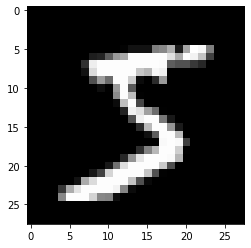

In [11]:
import matplotlib.pyplot as plt
with tf.device("CPU:0"):
    cpu_model = build_model(allow_cudnn_kernel=True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print( "Predicted result is: %s, target result is: %s" %(result.numpy(), sample_label) )
    plt.imshow(sample, cmap=plt.get_cmap("gray"))